In [1]:
import blocksci
import collections
import pandas as pd
import numpy as np
from pathlib import Path


parser_data_directory = Path("/mnt/anal/config.json")
cluster_directory = Path("/mnt/anal/cluster/")
dumplings_directory = Path("/mnt/dumplings/")

chain = blocksci.Blockchain(str(parser_data_directory))

from typing import Tuple

def get_block_height_for_date(date: str) -> int:
    return chain.range(date)[0].height

def get_block_height_range(start: str, end: str) -> Tuple[int, int]:
    return get_block_height_for_date(start), get_block_height_for_date(end)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def compute_cluster_graph(ww1, ww2, sw):
    sizes_ww1 = [cluster.address_count() for cluster in ww1]
    sizes_ww2 = [cluster.address_count() for cluster in ww2]
    sizes_sw = [cluster.address_count() for cluster in sw]
    
    df_ww1 = pd.DataFrame({'size': sizes_ww1})
    df_ww1['coordinator'] = 'Wasabi Wallet 1'
    
    df_ww2 = pd.DataFrame({'size': sizes_ww2})
    df_ww2['coordinator'] = 'Wasabi Wallet 2'
    
    df_sw = pd.DataFrame({'size': sizes_sw})
    df_sw['coordinator'] = 'Samourai Whirlpool'

    df_all = pd.concat([df_ww1, df_ww2, df_sw], ignore_index=True)
    
    df_all_sorted = df_all.groupby('coordinator').apply(lambda x: x.sort_values('size', ascending=False)).reset_index(drop=True)
    
    df_all_sorted['rank'] = df_all_sorted.groupby('coordinator').cumcount() + 1
    
    plt.figure(figsize=(10, 6))
    
    for name, group in df_all_sorted.groupby('coordinator'):
        plt.plot(group['rank'], group['size'], label=name)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of clusters')
    plt.ylabel('Cluster Size')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.title('Cluster Sizes for Coinjoin Coordinators')
    plt.legend()
    plt.savefig("/mnt/blocksci/all_clusters_distribution.png")
    plt.show()

# Wasabi2 clusters

In [ ]:
start = 0
stop = get_block_height_for_date('2024-10-31')

heuristic =  blocksci.heuristics.coinjoin.one_output_consolidation_2hops & blocksci.heuristics.coinjoin.fake_output_consolidation_1hop

%time clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering(  \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/wasabi2_2hop/", \
    overwrite=True, \
    coinjoin_type="wasabi2", \
    heuristic_func=heuristic, \
    max_distance=2 \
)


In [26]:
ww2_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi2_2hop/", chain)
%time ww2_clusters = [cluster for cluster in ww2_clusterer.clusters() if cluster.address_count() > 1]
%time ww2_clusters_full = [cluster for cluster in ww2_clusterer.clusters()]
print("full", len(ww2_clusters_full))
print("filtered", len(ww2_clusters))

CPU times: user 9.73 s, sys: 1.47 s, total: 11.2 s
Wall time: 11.2 s
CPU times: user 5.43 s, sys: 856 ms, total: 6.29 s
Wall time: 6.31 s
full 15975856
filtered 84449


# Whirlpool clusters
`9ea3e5d217c76e6be6ace7fe4fb3622976103466de81d2b02cd87c54f9e91a2f` should have 21 clustered addresses by the simple one output heuristics
`00ab23721356a159b695060b3975469fa0703e55398e9123ef59d2a5b94b1058` should have 567 addresses clustered

In [9]:
one_random_wp_cj = chain.tx_with_hash("9ea3e5d217c76e6be6ace7fe4fb3622976103466de81d2b02cd87c54f9e91a2f")
one_random_wp_cj = chain.tx_with_hash("00ab23721356a159b695060b3975469fa0703e55398e9123ef59d2a5b94b1058")
one_random_wp_cj = chain.tx_with_hash("021dc91d5d9d74babeed5dbf12a6287cbc4a46317afa357b45c46776940cf902")
address_im_looking_for = one_random_wp_cj.outputs[1].spending_tx.outputs[0].address

start = one_random_wp_cj.block_height
stop = one_random_wp_cj.block_height + 91302

start = 0
stop = get_block_height_for_date('2024-10-31')
heuristic =  blocksci.heuristics.coinjoin.one_output_consolidation_2hops & blocksci.heuristics.coinjoin.fake_output_consolidation_1hop



%time clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering(  \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/whirlpool_2hop/", \
    overwrite=True, \
    coinjoin_type="whirlpool", \
    heuristic_func=heuristic, \
    max_distance=2 \
)

Collected 5138453 addresses
Creating disjoint sets of size 5138453
Created disjoint sets of size 5138453
Preparing to serialize cluster data
CPU times: user 10min 48s, sys: 11.5 s, total: 11min
Wall time: 36.6 s


In [27]:
wp_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/whirlpool_2hop/", chain)
%time wp_clusters = [cluster for cluster in wp_clusterer.clusters() if cluster.address_count() > 1]
%time wp_clusters_full = [cluster for cluster in wp_clusterer.clusters()]
print("full", len(wp_clusters_full))
print("filtered", len(wp_clusters))


CPU times: user 2.83 s, sys: 107 ms, total: 2.94 s
Wall time: 2.95 s
CPU times: user 1.56 s, sys: 333 ms, total: 1.89 s
Wall time: 1.9 s
full 4550392
filtered 97668


# Wasabi1 clustering


In [19]:
start = 0
stop = get_block_height_for_date('2024-10-31')


heuristic =  blocksci.heuristics.coinjoin.one_output_consolidation_2hops & blocksci.heuristics.coinjoin.fake_output_consolidation_1hop

%time clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering(  \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/wasabi1_2hop/", \
    overwrite=True, \
    coinjoin_type="wasabi1", \
    heuristic_func=heuristic, \
    max_distance=2, \
)

Collected 10290298 addresses
Creating disjoint sets of size 10290298
Created disjoint sets of size 10290298
Preparing to serialize cluster data
CPU times: user 6min 7s, sys: 12.6 s, total: 6min 19s
Wall time: 55.4 s


In [28]:
ww1_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi1_2hop/", chain)
%time ww1_clusters = [cluster for cluster in ww1_clusterer.clusters() if cluster.address_count() > 1]
%time ww1_clusters_full = [cluster for cluster in ww1_clusterer.clusters()]
print("full", len(ww1_clusters_full))
print("filtered", len(ww1_clusters))

CPU times: user 5.88 s, sys: 101 ms, total: 5.98 s
Wall time: 6 s
CPU times: user 3.5 s, sys: 828 ms, total: 4.32 s
Wall time: 4.34 s
full 8779571
filtered 373002


## No clusters
not working yet :c

In [ ]:
start = 0
stop = get_block_height_for_date('2024-10-31')

heu = blocksci.heuristics.coinjoin.input_one_hop
heu = heu and blocksci.heuristics.coinjoin.output_three_hop_threshold
heu = heu and blocksci.heuristics.coinjoin.output_two_hop_threshold 
heu = heu and blocksci.heuristics.coinjoin.output_one_hop
heu = heu and blocksci.heuristics.coinjoin.output_one_hop_with_change


no_clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering( \
    chain=chain, \
    start=start, \
    stop=stop, \
    output_path="/mnt/anal/clustering/no_cj_out_threshold_change/", \
    overwrite=True, \
    coinjoin_type=blocksci.CoinJoinType.NoCJ, \
    heuristic_func=heu, \
)

In [ ]:
no_cj_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/no_cj_out_threshold_change/", chain)
%time no_cj_clusters = [cluster for cluster in no_cj_clusterer.clusters() if cluster.address_count() > 1]

## Results

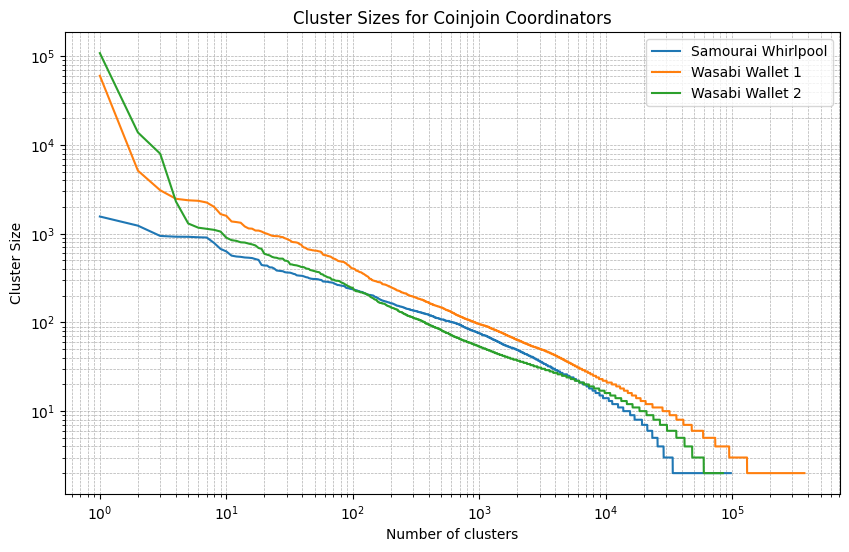

In [29]:
compute_cluster_graph(ww1_clusters, ww2_clusters, wp_clusters)

# Other cluster statistics

In [5]:
ww1_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi1_out_threshold_change2/", chain)
wp_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/whirlpool_out_threshold_change_no_input/", chain)
ww2_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi2_out_threshold_change2/", chain)

In [4]:
%time ww2_clusters = [cluster for cluster in ww2_clusterer.clusters() if cluster.address_count() > 1]
%time ww1_clusters = [cluster for cluster in ww1_clusterer.clusters() if cluster.address_count() > 1]
%time wp_clusters = [cluster for cluster in wp_clusterer.clusters() if cluster.address_count() > 1]


CPU times: user 11.6 s, sys: 3.6 s, total: 15.2 s
Wall time: 15.4 s
CPU times: user 6.96 s, sys: 1.94 s, total: 8.9 s
Wall time: 8.96 s
CPU times: user 3.29 s, sys: 222 ms, total: 3.51 s
Wall time: 3.53 s


In [24]:
from tabulate import tabulate

print(tabulate(
    [
        [
            "Wasabi Wallet 1", 
            10290298,
            len(ww1_clusters_full),
            len(ww1_clusters), 
            max(ww1_clusters, key=lambda c: c.address_count()).address_count()
        ],
        [
            "Wasabi Wallet 2", 
            16759406,
            len(ww2_clusters_full),
            len(ww2_clusters), 
            max(ww2_clusters, key=lambda c: c.address_count()).address_count()
        ],
        [
            "Samourai Whirlpool", 
            5138453,
            len(wp_clusters_full),
            len(wp_clusters), 
            max(wp_clusters, key=lambda c: c.address_count()).address_count()
        ],
        
    ],
    headers=['Pool', "Total addresses collected", "Total number of clusters", "Number of clusters", "Biggest cluster size"], 
    tablefmt='orgtbl'
    )
)


| Pool               |   Total addresses collected |   Total number of clusters |   Number of clusters |   Biggest cluster size |
|--------------------+-----------------------------+----------------------------+----------------------+------------------------|
| Wasabi Wallet 1    |                    10290298 |                    8779571 |               373002 |                  60519 |
| Wasabi Wallet 2    |                    16759406 |                   15975856 |                84449 |                 108845 |
| Samourai Whirlpool |                     5138453 |                    4550392 |                97668 |                   1565 |


In [26]:
def plot_biggest_clusters(ww1, ww2, sw, coordinator):

    def process(biggest_clusters):
        a: blocksci.Address
        
        all_cluster_transactions = set()

        for c in biggest_clusters:
            for tx in c.txes():
                all_cluster_transactions.add(tx)
        
        
        df_cluster = pd.DataFrame([(tx.block_time, 1) for tx in all_cluster_transactions], columns=["time", "count"])
        df_cluster["week_start"] = df_cluster["time"].dt.to_period("W").apply(lambda r: r.start_time)
        weekly_cluster = df_cluster.groupby("week_start")["count"].sum().reset_index()
        return weekly_cluster

    df_ww1 = process(ww1)
    df_ww2 = process(ww2)
    df_sw = process(sw)
    df_coordinator = process(coordinator)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_ww1['week_start'], df_ww1["count"], label="WW1", marker='o')
    plt.plot(df_ww2['week_start'], df_ww2["count"], label="WW2", marker='o')
    plt.plot(df_sw['week_start'], df_sw["count"], label="Whirlpool", marker='o')
    plt.plot(df_coordinator['week_start'], df_coordinator["count"], label="WW1 static coordinator addresses", ls='--')
    plt.grid(ls='--')

    plt.xlabel('Time')
    plt.ylabel('Transaction count')
    plt.yscale('log')
    plt.title('Activity of the addresses of the largest clusters')
    plt.legend()
    plt.savefig('/mnt/blocksci/activity_better_without_omni_2.png')
    plt.show()

In [45]:
ww1_largest_clusters = list(sorted(ww1_clusters, key=lambda c: c.address_count()))[-3:-1]
ww2_largest_clusters = list(sorted(ww2_clusters, key=lambda c: c.address_count()))[-3:-1]
sw_largest_clusters = list(sorted(wp_clusters, key=lambda c: c.address_count()))[-2:]

print(ww1_largest_clusters[0].address_count(), ww1_largest_clusters[1].address_count())
print(ww2_largest_clusters[0].address_count(), ww2_largest_clusters[1].address_count())
print(sw_largest_clusters[0].address_count(), sw_largest_clusters[1].address_count())

3095 5144
7995 13865
1234 1565


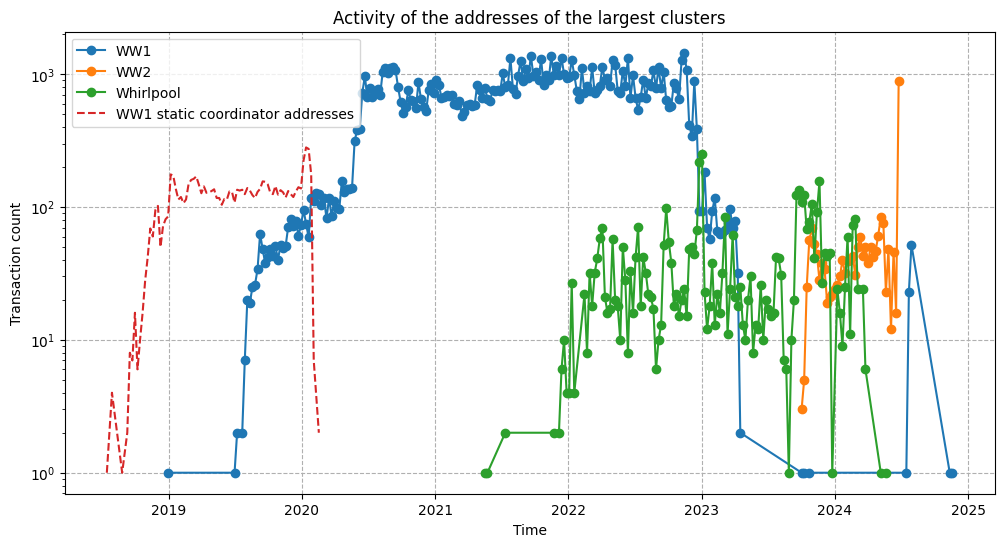

CPU times: user 1.57 s, sys: 1.33 s, total: 2.89 s
Wall time: 3.07 s


In [44]:
coordinator_cluster = [
    ww1_clusterer.cluster_with_address(chain.address_from_string("bc1qs604c7jv6amk4cxqlnvuxv26hv3e48cds4m0ew")), 
    ww1_clusterer.cluster_with_address(chain.address_from_string("bc1qa24tsgchvuxsaccp8vrnkfd85hrcpafg20kmjw"))
]

%time plot_biggest_clusters(ww1_largest_clusters, ww2_largest_clusters, sw_largest_clusters, coordinator_cluster)

In [32]:
ww1_biggest_cluster = max(ww1_clusters, key=lambda c: c.address_count())
ww2_biggest_cluster = max(ww2_clusters, key=lambda c: c.address_count())
sw_biggest_cluster = max(wp_clusters, key=lambda c: c.address_count())

In [37]:
%time most_used_addresses_sw = list(sorted(ww2_largest_clusters[0].addresses.to_list(), key=lambda a: a.input_txes_count() + a.output_txes_count()))
mua_sw = most_used_addresses_sw[-1]
print(mua_sw)

CPU times: user 243 ms, sys: 42.7 ms, total: 285 ms
Wall time: 287 ms
ScriptHashAddress(3NGDSAAb8bryY3JJ1Uj3y8hxBpFzxWa6kG, wrapped_address=bc1qnd336gk98lkzd79zudmr86phyrqz04lsc8ctmw)


# Tagged clusters

We use [graphsense-tagpacks](https://github.com/graphsense/graphsense-tagpacks/blob/master/actors/graphsense.actorpack.yaml) to tag the clusters we form with tags. Make sure to clone the repo and provide path to it in `TAGPACK_DIRECTORY` variable

### Loading

In [2]:
import yaml
import os

def join_tags(tag):
    if 'reserve' in tag:
        return 'Reserve'
    if 'hack' in tag or 'OFAC' in tag:
        return 'Illegal activity'
    if 'binance' in tag or 'exchange' in tag:
        return 'exchange'
    return None

TAGPACK_DIRECTORY = Path('/mnt/anal/graphsense-tagpacks')

with open(TAGPACK_DIRECTORY / 'actors' / 'graphsense.actorpack.yaml') as f:
    actors = yaml.safe_load(f)['actors']

packs = {}

def parse_address_currency_structure(data, packs):
    label = data.get('label')
    if not join_tags(label):
        return 
        
    tags = data['tags']
    currency = data.get('currency')
    for dct in tags:
        if dct.get('currency') == 'BTC' or currency == 'BTC':
            address = chain.address_from_string(dct['address'])
            if address is not None:
                packs[address] = join_tags(label)

def parse_label_actor_structure(data, packs):
    label = data.get('category') or data.get('abuse')
    if not label or not join_tags(label):
        return 
    currency = data.get('currency')
    actor = data.get('actor')
    if currency != 'BTC' and actor != 'binance':
        return 
        
    for dct in data['tags']:
        if currency is None and dct.get('currency') is None:
            continue
        address = chain.address_from_string(dct['address'])
        packs[address] = join_tags(label)



for root, _, files in os.walk(TAGPACK_DIRECTORY / 'packs'):
    for file in files:
        if file.endswith((".yaml", ".yml")):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as yaml_file:
                try:
                    data = yaml.safe_load(yaml_file)
                    label = data.get('label')
                    if label is None:
                        parse_label_actor_structure(data, packs)
                    else:
                        parse_address_currency_structure(data, packs)
                        
                    
                except yaml.YAMLError as e:
                    print(f"Error parsing {file_path}: {e}")
                except KeyError as e:
                    print(f"Error parsing {file_path}: {e}")
                except RuntimeError as e:
                    print(f"Error parsing {file_path}: {e}")


print(len(packs))

Error parsing /mnt/anal/graphsense-tagpacks/packs/exchange-wallets-binance.yaml: Tried to construct invalid address
337055


In [3]:
ww1_clusterer1 = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi1_1hop/", chain)
ww1_clusterer2 = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi1_2hop/", chain)
sw_clusterer1 = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/whirlpool_1hop/", chain)
sw_clusterer2 = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/whirlpool_2hop/", chain)
ww2_clusterer1 = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi2_1hop/", chain)
ww2_clusterer2 = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi2_2hop/", chain)

### Quick rundown

In [101]:
def plot_tagged_clusters(ww1, ww2, sw):

    def process(biggest_clusters):
        a: blocksci.Address
        
        all_cluster_transactions = set()

        for c in biggest_clusters:
            for tx in c.txes():
                all_cluster_transactions.add(tx)
        
        
        df_cluster = pd.DataFrame([(tx.block_time, 1) for tx in all_cluster_transactions], columns=["time", "count"])
        df_cluster["week_start"] = df_cluster["time"].dt.to_period("W").apply(lambda r: r.start_time)
        weekly_cluster = df_cluster.groupby("week_start")["count"].sum().reset_index()
        return weekly_cluster

    df_ww1 = process(ww1)
    df_ww2 = process(ww2)
    df_sw = process(sw)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_ww1['week_start'], df_ww1["count"], label="WW1", linewidth=0.7)
    plt.plot(df_ww2['week_start'], df_ww2["count"], label="WW2", linewidth=0.7)
    plt.plot(df_sw['week_start'], df_sw["count"], label="Whirlpool", linewidth=0.7)
    plt.grid(ls='--')

    plt.xlabel('Time')
    plt.ylabel('Transaction count')
    plt.title('Activity of the addresses of the clusters labeled as "Alt-right entity"')
    plt.legend()
    # plt.savefig('/mnt/blocksci/activity.png')
    plt.show()

---- label: ww1 ----
---- label: sw ----
---- label: ww2 ----


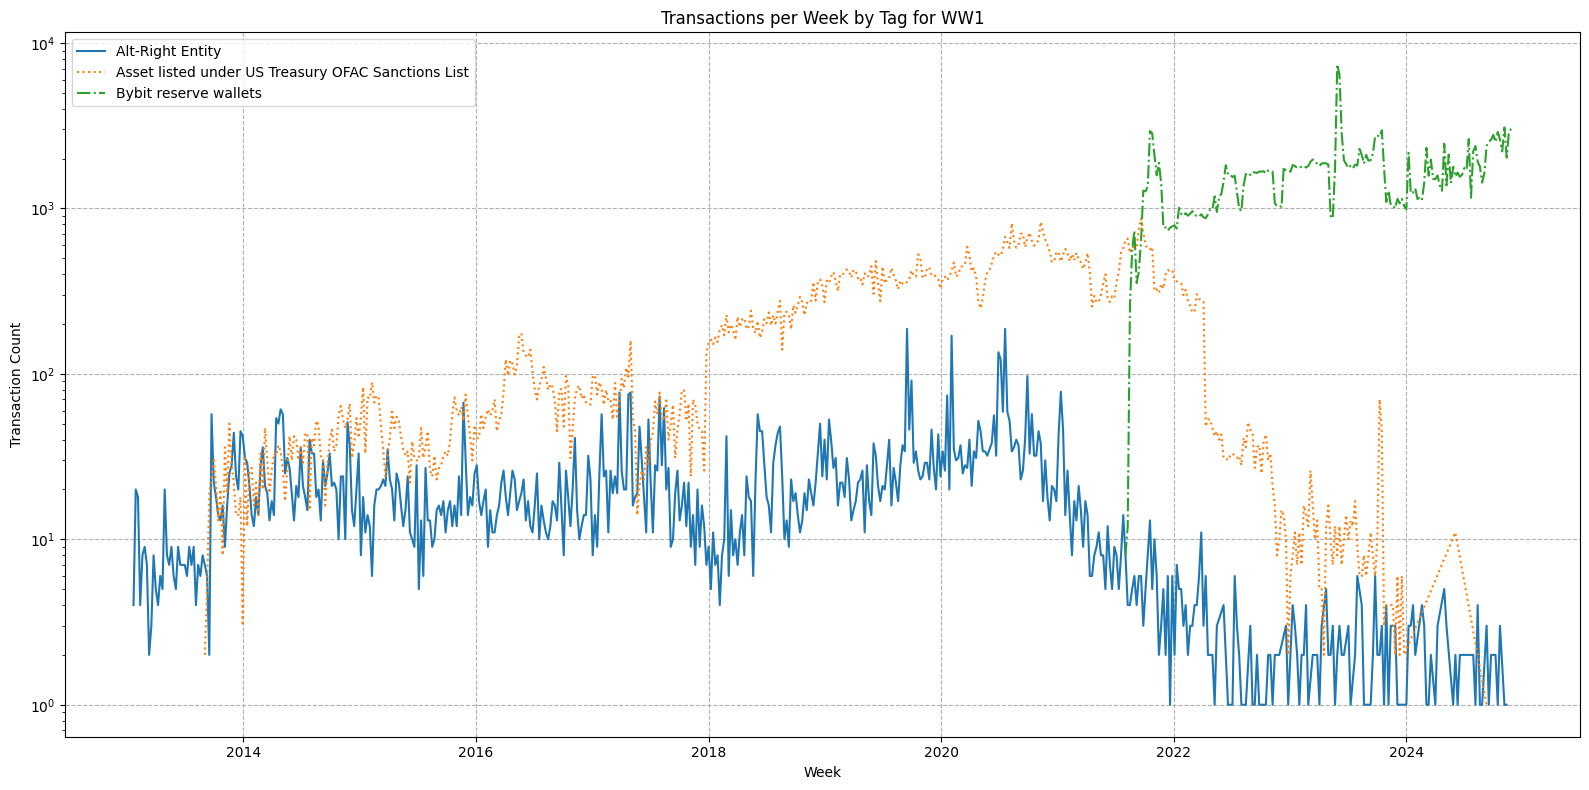

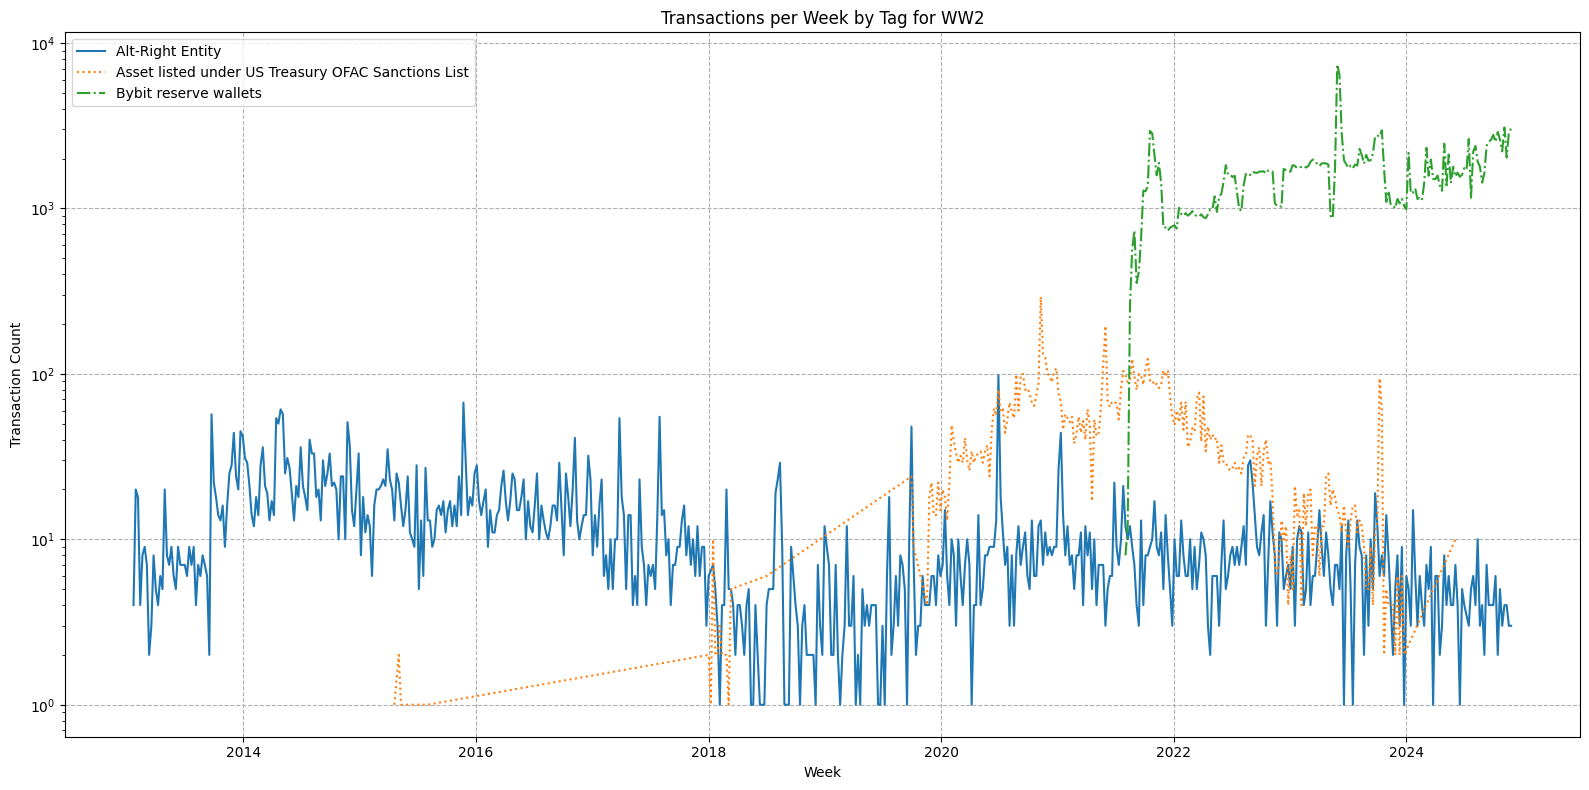

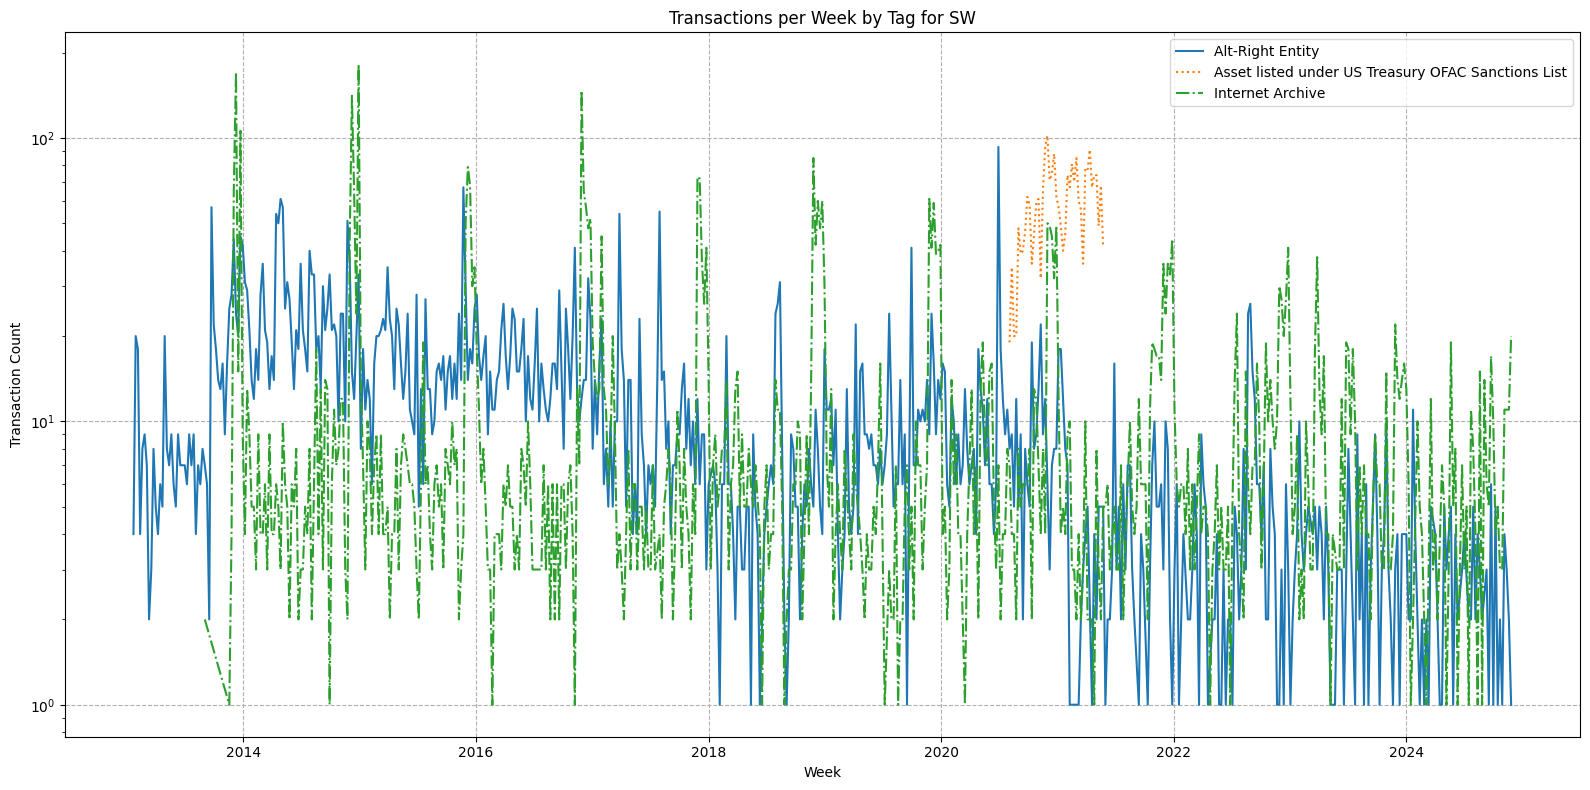

In [7]:
def tagged_clusters_evaluation(clusterer, label):
    print(f"---- label: {label} ----")
    if None in packs:
        packs.pop(None)
    
    tagged_clusters = clusterer.tagged_clusters(packs)
    processed_addresses = set()
    
    a: blocksci.cluster.TaggedAddress
    notable_labels = {}
    
    for tc in tagged_clusters:
        ta = tc.tagged_addresses
        for a in ta:
            if a.address in processed_addresses:
                continue
            processed_addresses.add(a.address)
            
            if a.tag not in notable_labels:
                notable_labels[a.tag] = []
            
            notable_labels[a.tag].append(clusterer.cluster_with_address(a.address))

    
    return notable_labels

def plot_label_cluster_graph_interactions(data, graph_label):
    rows = []

    for tag, clusters in data.items():
        for cluster in clusters:
            for tx in cluster.txes():
                rows.append({
                    "tag": tag,
                    "time": tx.block_time,
            })
    
    df = pd.DataFrame(rows)
    df['week'] = df['time'].dt.to_period('W').dt.start_time
    grouped = df.groupby(['tag', 'week']).size().reset_index(name='tx_count')
    
    # Plot the data
    plt.figure(figsize=(16, 8))
    for tag, ls in zip(grouped['tag'].unique(), ['-', ':', '-.']):
        tag_data = grouped[grouped['tag'] == tag]
        plt.plot(tag_data['week'], tag_data['tx_count'], label=tag, ls=ls)

    plt.xlabel("Week")
    plt.ylabel("Transaction Count")
    plt.yscale('log')

    plt.title(f"Transactions per Week by Tag for {graph_label}")
    plt.legend()
    plt.tight_layout()
    plt.grid(ls='--')
    #plt.savefig(f"tagged_clusters_{graph_label}.png")
    plt.show()
    



ww1_tagged_clusters = tagged_clusters_evaluation(ww1_clusterer, "ww1")
sw_tagged_clusters = tagged_clusters_evaluation(wp_clusterer, "sw")
ww2_tagged_clusters = tagged_clusters_evaluation(ww2_clusterer, "ww2")

plot_label_cluster_graph_interactions(ww1_tagged_clusters, "WW1")
plot_label_cluster_graph_interactions(ww2_tagged_clusters, "WW2")
plot_label_cluster_graph_interactions(sw_tagged_clusters, "SW")



### Big graphs

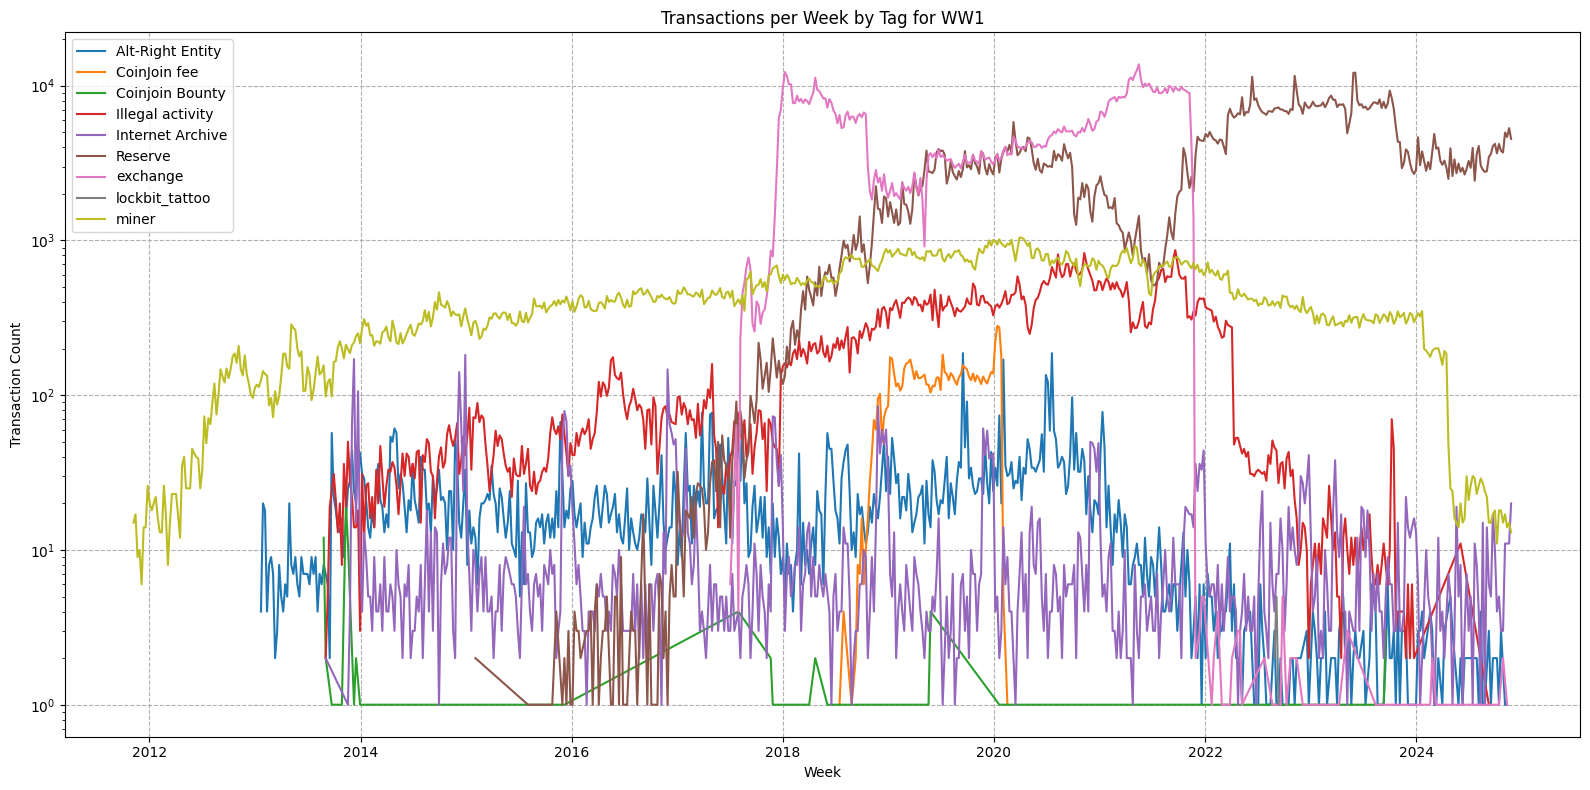

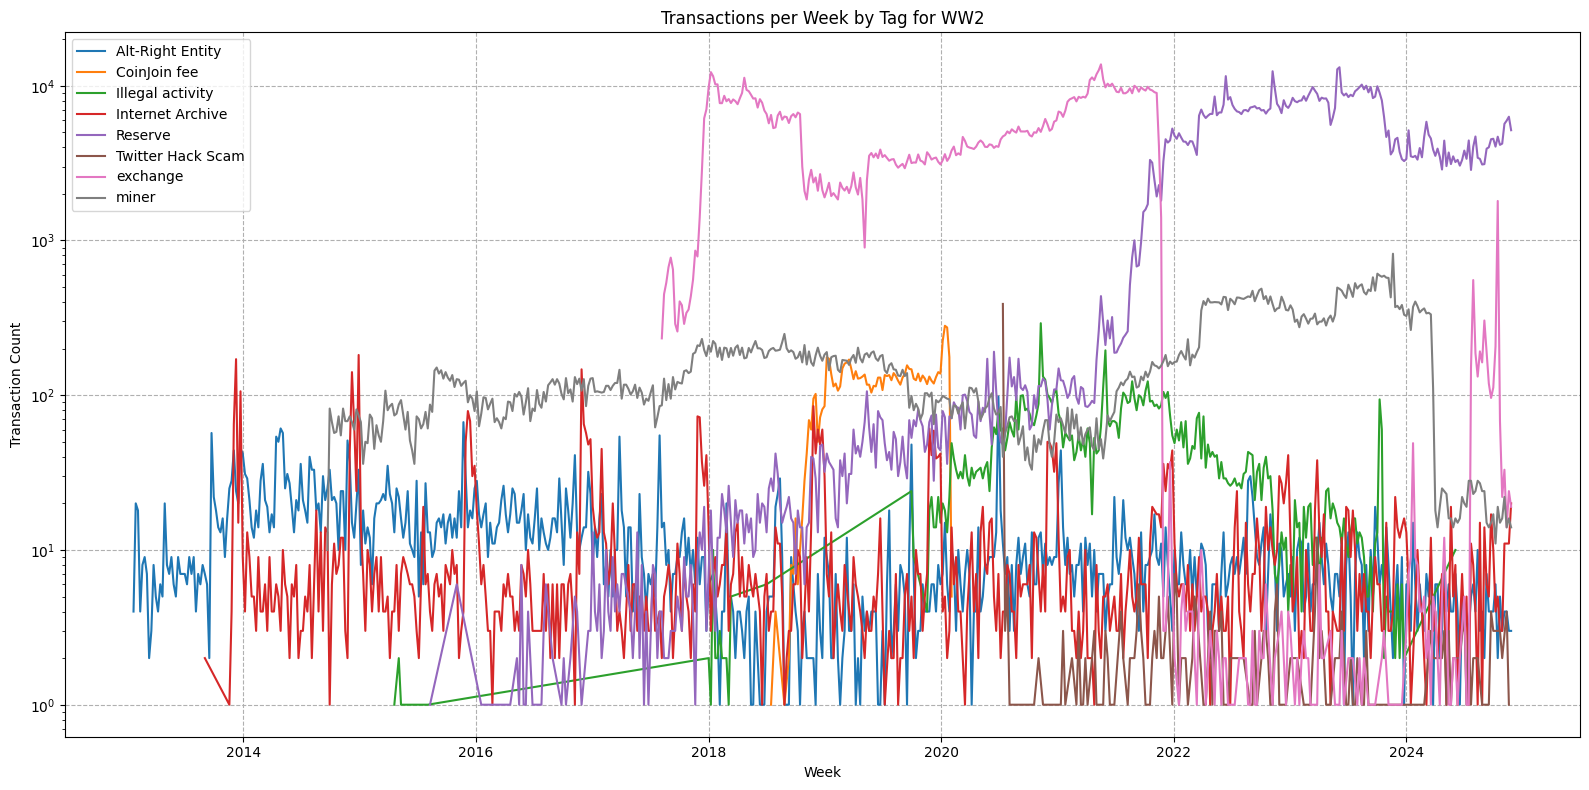

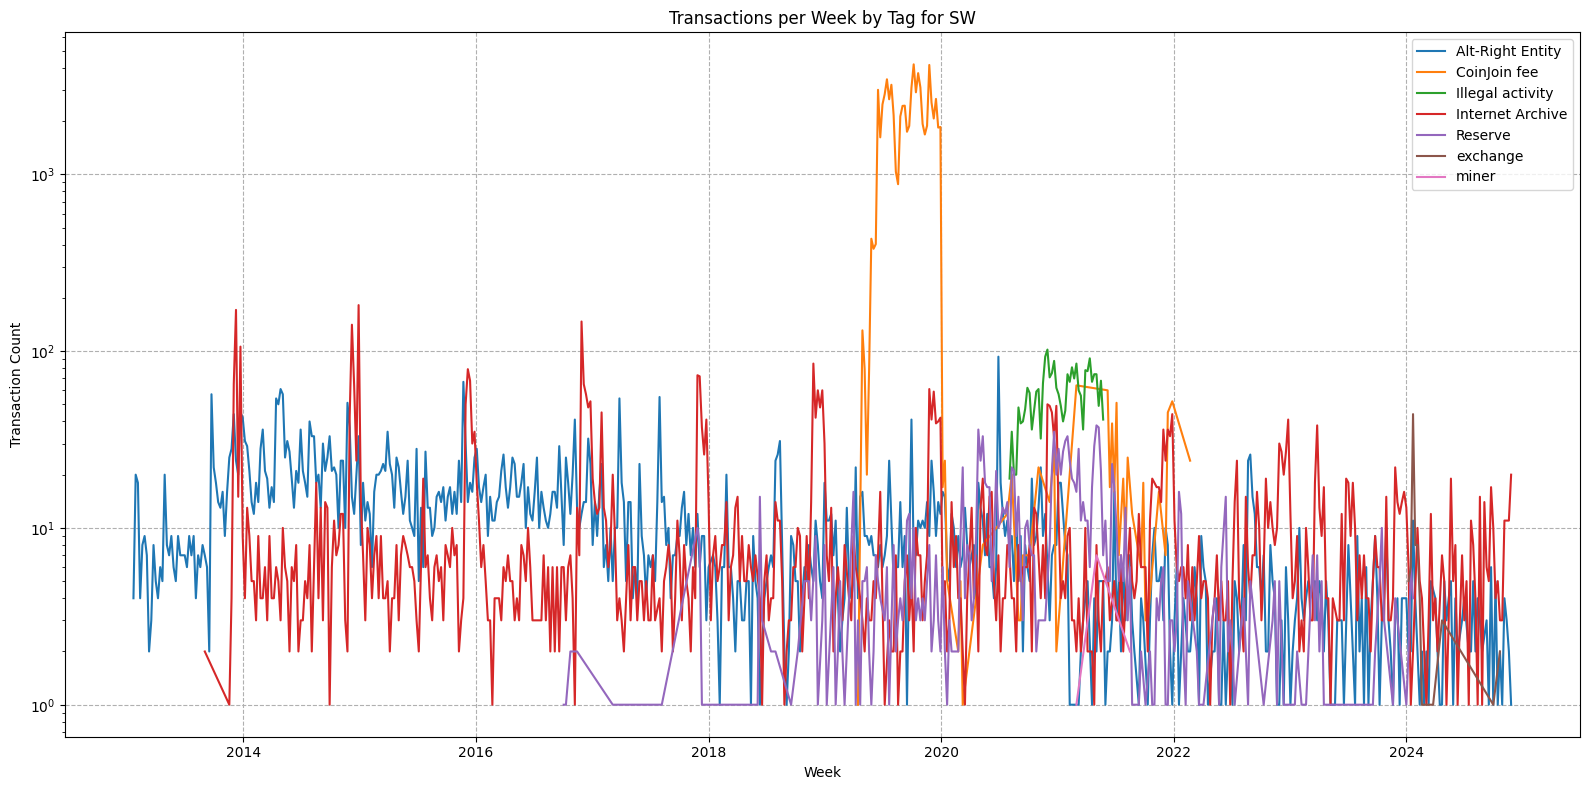

In [11]:
def plot_label_cluster_graph_interactions(data, graph_label):
    rows = []

    def join_tags(tag):
        if 'reserve' in tag:
            return 'Reserve'
        if 'wasabi' in tag.lower() or 'samourai' in tag.lower():
            return 'CoinJoin fee'
        if 'hack' in tag or 'OFAC' in tag:
            return 'Illegal activity'
        if 'binance' in tag or 'exchange' in tag:
            return 'exchange'
        return tag
    
    for tag, clusters in data.items():
        for cluster in clusters:
            for tx in cluster.txes():
                rows.append({
                    "tag": join_tags(tag),
                    "time": tx.block_time,
            })
    
    df = pd.DataFrame(rows)
    df['week'] = df['time'].dt.to_period('W').dt.start_time
    grouped = df.groupby(['tag', 'week']).size().reset_index(name='tx_count')
    
    # Plot the data
    plt.figure(figsize=(16, 8))
    for tag in grouped['tag'].unique():
        tag_data = grouped[grouped['tag'] == tag]
        plt.plot(tag_data['week'], tag_data['tx_count'], label=tag)

    plt.xlabel("Week")
    plt.ylabel("Transaction Count")
    plt.yscale('log')

    plt.title(f"Transactions per Week by Tag for {graph_label}")
    plt.legend()
    plt.tight_layout()
    plt.grid(ls='--')
    plt.savefig(f"tagged_clusters_{graph_label}.png")
    plt.show()


plot_label_cluster_graph_interactions(ww1_tagged_clusters, "WW1")
plot_label_cluster_graph_interactions(ww2_tagged_clusters, "WW2")
plot_label_cluster_graph_interactions(sw_tagged_clusters, "SW")
    

### Different k

We check the differences in activities for 3 labels - reserve, illegal activity, exchange, for distance 1 and 2 hops

### Tagged clusters

In [7]:
def tagged_clusters_comparison(clusterer, label):
    print(f"---- label: {label} ----")
    if None in packs:
        packs.pop(None)
    
    tagged_clusters = clusterer.tagged_clusters(packs)
    processed_addresses = set()
    
    a: blocksci.cluster.TaggedAddress
    notable_labels = {}
    tc: blocksci.cluster.TaggedCluster

    c = 0
    for tc in tagged_clusters:
        cluster: blocksci.cluster.Cluster = tc.cluster
        for address in tc.tagged_addresses:
            if address.tag not in notable_labels:
                notable_labels[address.tag] = []
            
            notable_labels[address.tag].append(cluster)
            break

            
    return notable_labels

%time ww1_tagged_clusters2 = tagged_clusters_comparison(ww1_clusterer2, "ww1")
%time sw_tagged_clusters2 = tagged_clusters_comparison(sw_clusterer2, "sw")
%time ww2_tagged_clusters2 = tagged_clusters_comparison(ww2_clusterer2, "ww2")


x
---- label: ww1 ----
CPU times: user 19min 58s, sys: 647 ms, total: 19min 58s
Wall time: 20min 5s
---- label: sw ----
CPU times: user 11.4 s, sys: 37.8 ms, total: 11.5 s
Wall time: 11.5 s
---- label: ww2 ----
CPU times: user 2min 32s, sys: 281 ms, total: 2min 33s
Wall time: 2min 33s


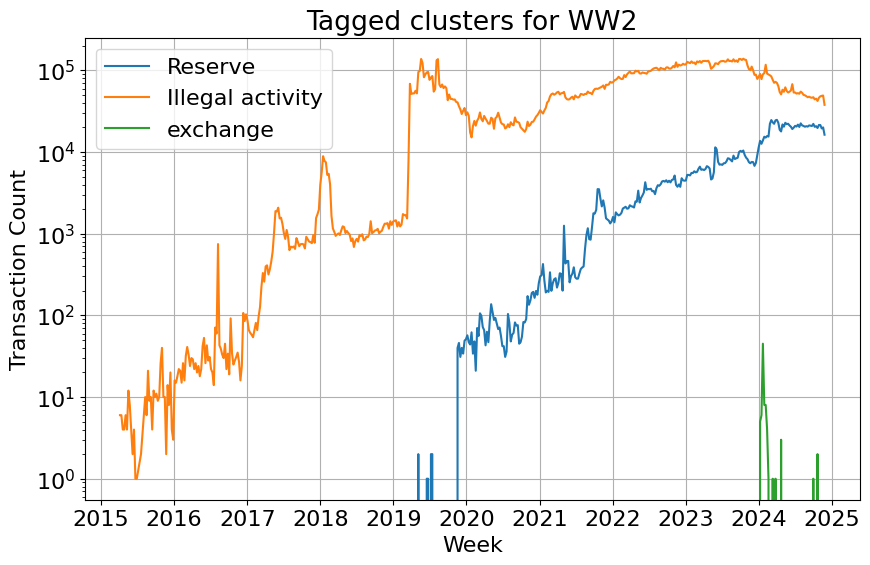

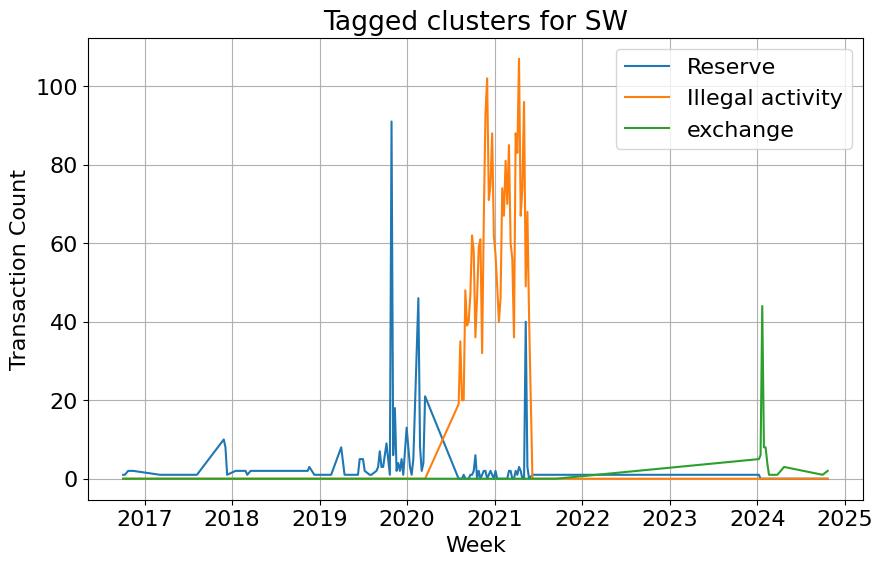

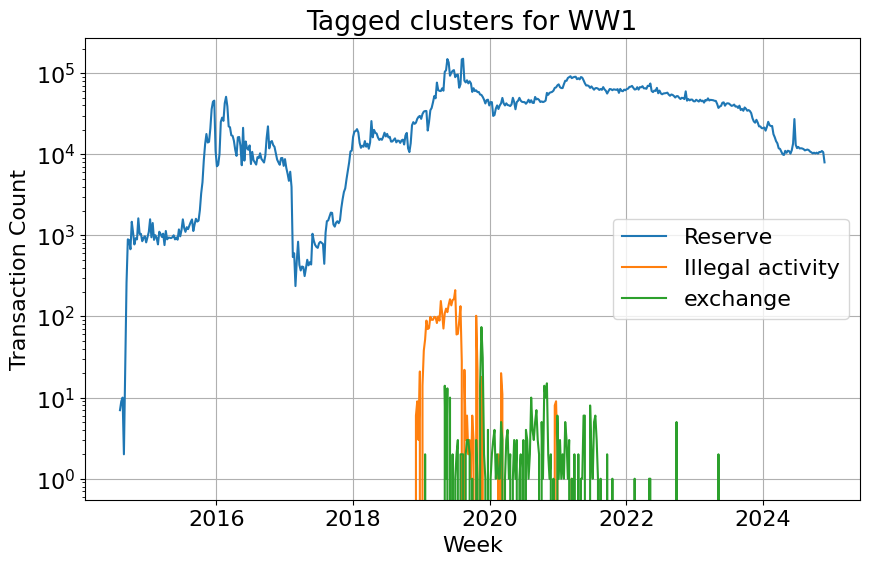

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


def plot_label_cluster_graph_interactions_hops(data1hop, data2hop, graph_label):
    rows = []
                
    for tag, clusters in data2hop.items():
        cluster = clusters[-1]
        for tx in cluster.txes():
            rows.append({
                "tag": tag,
                "time": tx.block_time,
        })

    df = pd.DataFrame(rows)
    df['week'] = df['time'].dt.to_period('W').dt.start_time
    grouped = df.groupby(['week', 'tag']).size().reset_index(name='count')
        
    pivoted = grouped.pivot(index='week', columns=['tag'], values='count').fillna(0)
    
    # Plot
    tags = df['tag'].unique()
    
    plt.figure(figsize=(10, 6))
    
    for tag in tags:
        if tag in pivoted.columns:
            plt.plot(
                pivoted.index, pivoted[tag],
                linestyle='solid',
                label=f"{tag}"
            )
    
    # Customize plot
    plt.rcParams.update({'font.size': 16})
    plt.xlabel('Week')
    plt.ylabel('Transaction Count')
    if graph_label != "SW":
        plt.yscale('log')
        
    plt.title(f'Tagged clusters for {graph_label}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"/mnt/blocksci/tagged_clusters_3tags_{graph_label}.png")
    plt.show()

plot_label_cluster_graph_interactions_hops([], ww2_tagged_clusters2, "WW2")
plot_label_cluster_graph_interactions_hops([], sw_tagged_clusters2, "SW")
plot_label_cluster_graph_interactions_hops([], ww1_tagged_clusters2, "WW1")


### Appendix graphs

Collected 10290298 addresses
Creating disjoint sets of size 10290298
Created disjoint sets of size 10290298
Preparing to serialize cluster data
Collected 16759406 addresses
Creating disjoint sets of size 16759406
Created disjoint sets of size 16759406
Preparing to serialize cluster data
Collected 5138453 addresses
Creating disjoint sets of size 5138453
Created disjoint sets of size 5138453
Preparing to serialize cluster data
--------------------------------------------------------------------------------
Threshold


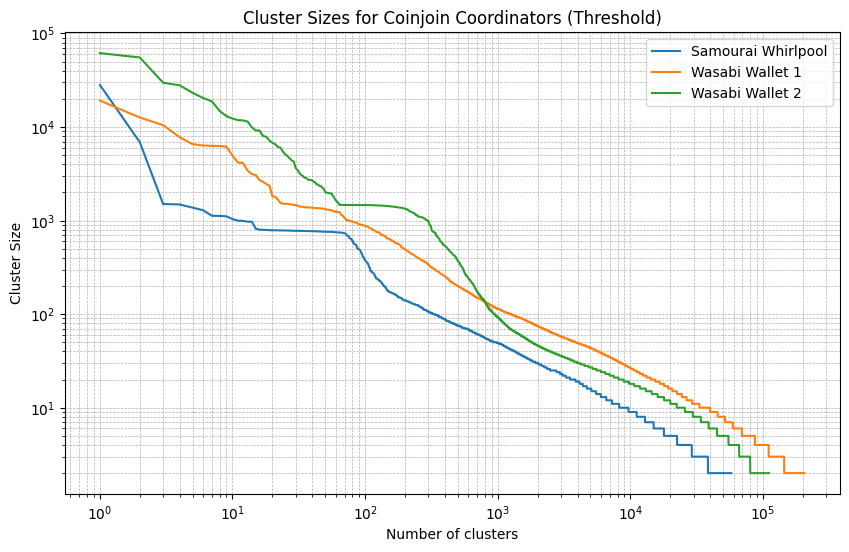

| Pool               |   Total addresses collected |   Total number of clusters |   Number of clusters |   Biggest cluster size |
|--------------------+-----------------------------+----------------------------+----------------------+------------------------|
| Wasabi Wallet 1    |                    10290298 |                    8573688 |               205304 |                  19210 |
| Wasabi Wallet 2    |                    16759406 |                   15047571 |               111072 |                  61655 |
| Samourai Whirlpool |                     5138453 |                    4675950 |                57577 |                  28210 |
--------------------------------------------------------------------------------

Collected 10290298 addresses
Creating disjoint sets of size 10290298
Created disjoint sets of size 10290298
Preparing to serialize cluster data
Collected 16759406 addresses
Creating disjoint sets of size 16759406
Created disjoint sets of size 16759406
Preparing to ser

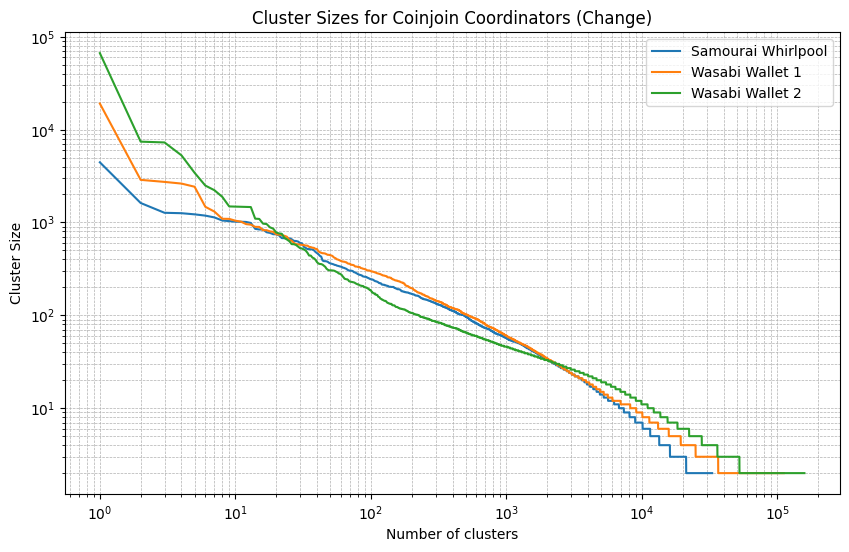

| Pool               |   Total addresses collected |   Total number of clusters |   Number of clusters |   Biggest cluster size |
|--------------------+-----------------------------+----------------------------+----------------------+------------------------|
| Wasabi Wallet 1    |                    10290298 |                    9790467 |               111329 |                  19046 |
| Wasabi Wallet 2    |                    16759406 |                   16118230 |               158010 |                  66502 |
| Samourai Whirlpool |                     5138453 |                    4799234 |                32952 |                   4438 |
--------------------------------------------------------------------------------

Collected 10290298 addresses
Creating disjoint sets of size 10290298
Created disjoint sets of size 10290298
Preparing to serialize cluster data
Collected 16759406 addresses
Creating disjoint sets of size 16759406
Created disjoint sets of size 16759406
Preparing to ser

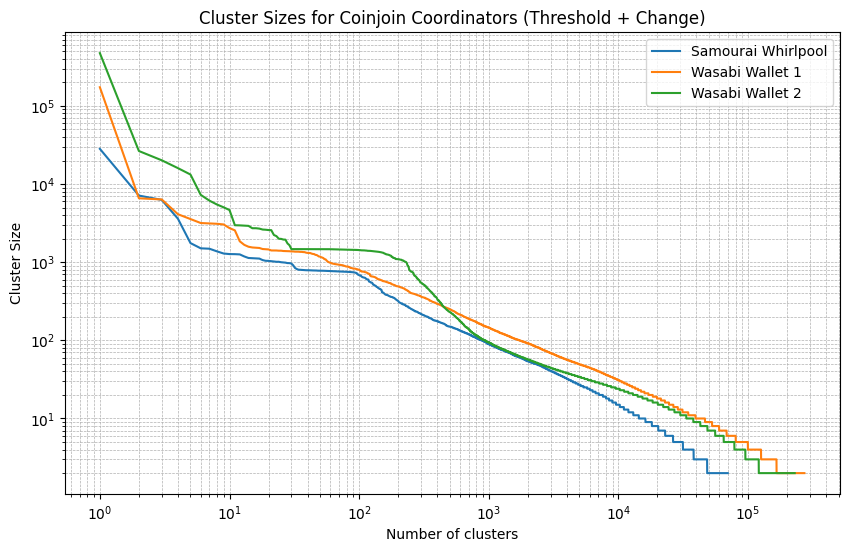

| Pool               |   Total addresses collected |   Total number of clusters |   Number of clusters |   Biggest cluster size |
|--------------------+-----------------------------+----------------------------+----------------------+------------------------|
| Wasabi Wallet 1    |                    10290298 |                    8156124 |               271899 |                 173328 |
| Wasabi Wallet 2    |                    16759406 |                   14547216 |               228850 |                 473226 |
| Samourai Whirlpool |                     5138453 |                    4362784 |                69682 |                  28210 |
--------------------------------------------------------------------------------

Collected 10290298 addresses
Creating disjoint sets of size 10290298
Created disjoint sets of size 10290298
Preparing to serialize cluster data
Collected 16759406 addresses
Creating disjoint sets of size 16759406
Created disjoint sets of size 16759406
Preparing to ser

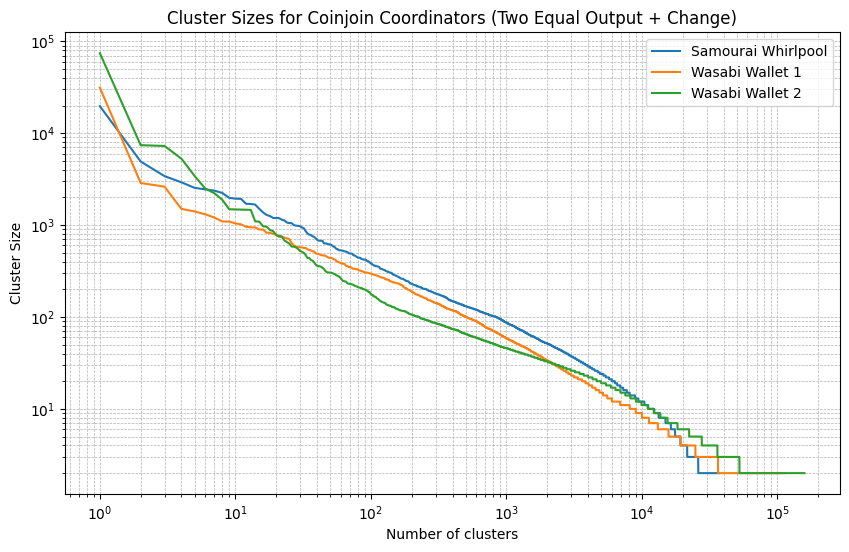

| Pool               |   Total addresses collected |   Total number of clusters |   Number of clusters |   Biggest cluster size |
|--------------------+-----------------------------+----------------------------+----------------------+------------------------|
| Wasabi Wallet 1    |                    10290298 |                    9785544 |               111177 |                  31366 |
| Wasabi Wallet 2    |                    16759406 |                   16110906 |               157973 |                  74372 |
| Samourai Whirlpool |                     5138453 |                    4565770 |                36960 |                  19715 |
--------------------------------------------------------------------------------

Collected 10290298 addresses
Creating disjoint sets of size 10290298
Created disjoint sets of size 10290298
Preparing to serialize cluster data
Collected 16759406 addresses
Creating disjoint sets of size 16759406
Created disjoint sets of size 16759406
Preparing to ser

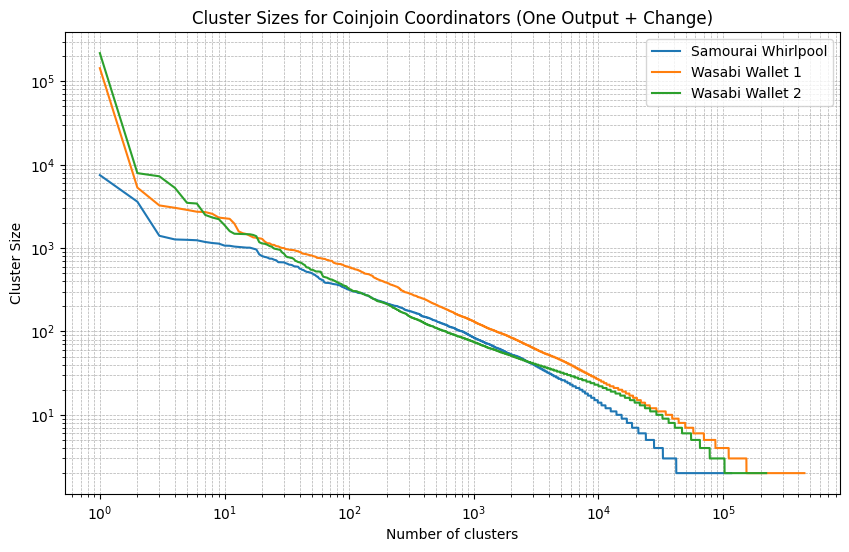

| Pool               |   Total addresses collected |   Total number of clusters |   Number of clusters |   Biggest cluster size |
|--------------------+-----------------------------+----------------------------+----------------------+------------------------|
| Wasabi Wallet 1    |                    10290298 |                    8284450 |               448586 |                 143916 |
| Wasabi Wallet 2    |                    16759406 |                   15348031 |               221371 |                 218076 |
| Samourai Whirlpool |                     5138453 |                    4444547 |               115873 |                   7510 |
--------------------------------------------------------------------------------

Collected 10290298 addresses
Creating disjoint sets of size 10290298
Created disjoint sets of size 10290298
Preparing to serialize cluster data
Collected 16759406 addresses
Creating disjoint sets of size 16759406
Created disjoint sets of size 16759406
Preparing to ser

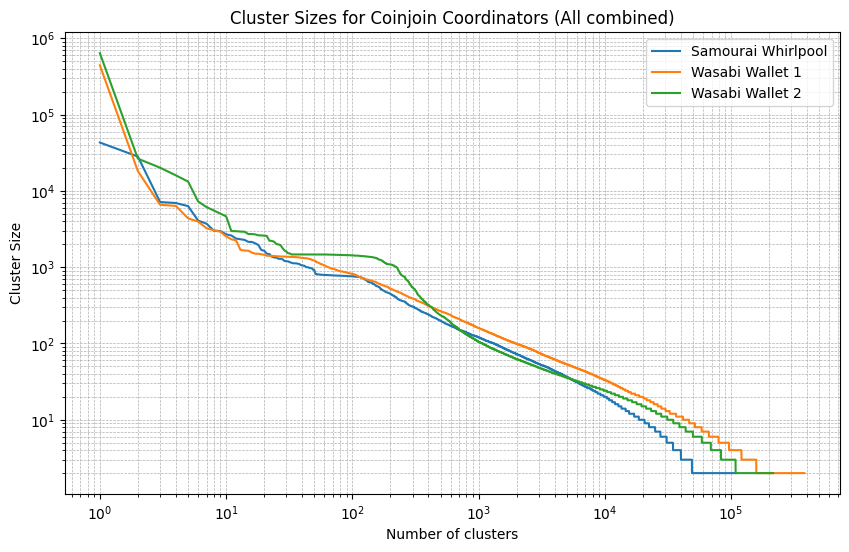

| Pool               |   Total addresses collected |   Total number of clusters |   Number of clusters |   Biggest cluster size |
|--------------------+-----------------------------+----------------------------+----------------------+------------------------|
| Wasabi Wallet 1    |                    10290298 |                    7686651 |               380774 |                 443099 |
| Wasabi Wallet 2    |                    16759406 |                   14436494 |               215033 |                 639227 |
| Samourai Whirlpool |                     5138453 |                    4046441 |               108221 |                  43070 |
--------------------------------------------------------------------------------



In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate


start = 0
stop = get_block_height_for_date('2024-10-31')
cj_module = blocksci.heuristics.coinjoin

def compute_cluster_graph_appendix(ww1, ww2, sw, label):
    sizes_ww1 = [cluster.address_count() for cluster in ww1]
    sizes_ww2 = [cluster.address_count() for cluster in ww2]
    sizes_sw = [cluster.address_count() for cluster in sw]
    
    df_ww1 = pd.DataFrame({'size': sizes_ww1})
    df_ww1['coordinator'] = 'Wasabi Wallet 1'
    
    df_ww2 = pd.DataFrame({'size': sizes_ww2})
    df_ww2['coordinator'] = 'Wasabi Wallet 2'
    
    df_sw = pd.DataFrame({'size': sizes_sw})
    df_sw['coordinator'] = 'Samourai Whirlpool'

    df_all = pd.concat([df_ww1, df_ww2, df_sw], ignore_index=True)
    
    # Sort the sizes in descending order for each coordinator
    df_all_sorted = df_all.groupby('coordinator').apply(lambda x: x.sort_values('size', ascending=False)).reset_index(drop=True)
    
    # Add a rank column for plotting
    df_all_sorted['rank'] = df_all_sorted.groupby('coordinator').cumcount() + 1
    
    # Plot the size vs. rank for each coordinator on a log-log scale
    plt.figure(figsize=(10, 6))
    
    for name, group in df_all_sorted.groupby('coordinator'):
        plt.plot(group['rank'], group['size'], label=name)
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Number of clusters')
    plt.ylabel('Cluster Size')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    plt.title(f'Cluster Sizes for Coinjoin Coordinators ({label})')
    plt.legend()
    plt.savefig(f"/mnt/blocksci/opraski/all_clusters_appendix_{label.lower().replace(' ', '_')}.png")
    plt.show()


def plot_biggest_clusters_2(ww1, ww2, sw, title):

    def process(biggest_clusters):
        a: blocksci.Address
        
        all_cluster_transactions = set()

        for c in biggest_clusters:
            for tx in c.txes():
                all_cluster_transactions.add(tx)
        
        
        df_cluster = pd.DataFrame([(tx.block_time, 1) for tx in all_cluster_transactions], columns=["time", "count"])
        df_cluster["week_start"] = df_cluster["time"].dt.to_period("W").apply(lambda r: r.start_time)
        weekly_cluster = df_cluster.groupby("week_start")["count"].sum().reset_index()
        return weekly_cluster

    df_ww1 = process(ww1)
    df_ww2 = process(ww2)
    df_sw = process(sw)
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(df_ww1['week_start'], df_ww1["count"], label="WW1", marker='o')
    plt.plot(df_ww2['week_start'], df_ww2["count"], label="WW2", marker='o')
    plt.plot(df_sw['week_start'], df_sw["count"], label="Whirlpool", marker='o')
    plt.grid(ls='--')

    plt.xlabel('Time')
    plt.ylabel('Transaction count')
    plt.yscale('log')
    plt.title(f'Activity in the largest clusters ({title})')
    plt.legend()
    plt.savefig(f'/mnt/blocksci/opraski/activity_{title.lower().replace(" ", "_")}.png')
    plt.show()

heuristic_tag_mapping = {
    "Threshold": cj_module.output_threshold_consolidation_2hops,
    "Change": cj_module.one_output_consolidation_with_change_2hops,
    "Threshold + Change": cj_module.one_output_consolidation_with_change_2hops & cj_module.output_threshold_consolidation_2hops,
    "Two Equal Output + Change": cj_module.one_output_consolidation_with_change_2hops & cj_module.fake_output_consolidation_2hops,
    "One Output + Change": cj_module.one_output_consolidation_with_change_2hops & cj_module.one_output_consolidation_2hops,
    "All combined": cj_module.one_output_consolidation_with_change_2hops & cj_module.fake_output_consolidation_2hops & cj_module.output_threshold_consolidation_2hops & cj_module.one_output_consolidation_2hops,
}

cj_types = ["wasabi1", "wasabi2", "whirlpool"]

for heu_name, heu in heuristic_tag_mapping.items():
    for cj in cj_types:
        clusterer = blocksci.cluster.CoinjoinClusterManager.create_clustering(  \
            chain=chain, \
            start=start, \
            stop=stop, \
            output_path=f"/mnt/anal/clustering/{cj}_extra_appendix/", \
            overwrite=True, \
            coinjoin_type=cj, \
            heuristic_func=heu, \
            max_distance=2, \
        )

    ww1_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi1_extra_appendix/", chain)
    ww2_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/wasabi2_extra_appendix/", chain)
    sw_clusterer = blocksci.cluster.CoinjoinClusterManager("/mnt/anal/clustering/whirlpool_extra_appendix/", chain)
    ww1_clusters = [cluster for cluster in ww1_clusterer.clusters() if cluster.address_count() > 1]
    ww1_clusters_full = [cluster for cluster in ww1_clusterer.clusters()]
    ww2_clusters = [cluster for cluster in ww2_clusterer.clusters() if cluster.address_count() > 1]
    ww2_clusters_full = [cluster for cluster in ww2_clusterer.clusters()]
    sw_clusters = [cluster for cluster in sw_clusterer.clusters() if cluster.address_count() > 1]
    sw_clusters_full = [cluster for cluster in sw_clusterer.clusters()]

    print("-" * 80)
    print(heu_name)

    compute_cluster_graph_appendix(ww1_clusters, ww2_clusters, sw_clusters, heu_name)

    print(tabulate(
    [
        [
            "Wasabi Wallet 1", 
            10290298,
            len(ww1_clusters_full),
            len(ww1_clusters), 
            max(ww1_clusters, key=lambda c: c.address_count()).address_count()
        ],
        [
            "Wasabi Wallet 2", 
            16759406,
            len(ww2_clusters_full),
            len(ww2_clusters), 
            max(ww2_clusters, key=lambda c: c.address_count()).address_count()
        ],
        [
            "Samourai Whirlpool", 
            5138453,
            len(sw_clusters_full),
            len(sw_clusters), 
            max(sw_clusters, key=lambda c: c.address_count()).address_count()
        ],
        
    ],
    headers=['Pool', "Total addresses collected", "Total number of clusters", "Number of clusters", "Biggest cluster size"], 
    tablefmt='orgtbl'
    )
)

    print("-" * 80)
    print()

